# Analyzing UFO Sighting Times

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy.stats as stats
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
print(sys.version)

3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]


In [3]:
parent = os.path.dirname(os.getcwd())
ufo = pd.read_pickle(parent + '/data/cleaned_nuforc_reports_07202018.pkl') #UFO SIGHTINGS
airport = pd.read_csv(parent + '/data/airportData.csv') #AIRPORT LOCATIONS
military = pd.read_csv(parent + '/data/militaryData.csv') #MILITARY BASE LOCATIONS

In [4]:
ufo.head()

,Occurred,Reported,Posted,Location,Shape,Duration,Report,Sighting Time,Report Time,Latitude,Longitude,Shape Categories Revised
0,1996-06-24 00:30:00,1996-06-26 12:42:00,1999-11-02,"Aurora, CO",Changing,1 hour,Referred to Marilyn Childs to call CO state di...,00:30,12:42,39.729432,-104.831920,[Changing]
1,NaT,2006-03-21 12:11:00,2006-05-15,"Bristol, PA",Light,About 1 min.,"Hi, I am an avid sky watcher and usually I not...",NaN,12:11,40.100666,-74.851831,[Light]
2,2018-10-21 00:45:00,2015-05-16 00:34:00,2015-05-22,"Saskatoon (Canada), SK",Light,2 minutes,We seemed to know to look up and and for me it...,00:45,12:34,52.157331,-106.529930,"[Light, Circle]"
3,2018-10-21 01:00:00,2001-10-21 11:50:00,2001-11-20,Dublin,Light,a few seconds,"A ball of light, lighting up my pitch dark roo...",01:00,11:50,53.349764,-6.260273,[Light]
4,2018-10-21 01:00:00,1999-09-02 09:52:00,2003-02-05,"Careywood & Bayview, ID",Light,few minutes,"Ball of light similiar to reported ""Earht Ligh...",01:00,09:52,NaN,NaN,[Light]


In [5]:
#DROP UFO FEATURE COLUMNS WE WON'T BE USING IN THIS NOTEBOOK.
ufo = ufo.drop(['Report','Shape Categories Revised','Duration'], axis=1)

In [6]:
airport.head()

,Type,City,StateName,ARPLatitude,ARPLatitudeS,ARPLongitude,ARPLongitudeS,ActiviationDate
0,AIRPORT,ADAK ISLAND,ALASKA,51-53-00.8954N,186780.8954N,176-38-32.9277W,635912.9277W,04/01/1949
1,AIRPORT,AKHIOK,ALASKA,56-56-19.2870N,204979.2870N,154-10-57.2000W,555057.2000W,11/01/1979
2,AIRPORT,AKIACHAK,ALASKA,60-54-49.7150N,219289.7150N,161-29-35.9850W,581375.9850W,01/01/1968
3,SEAPLANE BASE,AKIACHAK,ALASKA,60-54-28.3130N,219268.3130N,161-26-06.2780W,581166.2780W,07/01/1966
4,AIRPORT,AKIAK,ALASKA,60-54-10.4300N,219250.4300N,161-13-50.1000W,580430.1000W,07/01/1966


In [7]:
def convert_tude(tude):
    multiplier = 1 if tude[-1] in ['N','E'] else -1
    return multiplier * np.sum(np.float(x)/(60**n) for n,x in enumerate(tude[:-1].split('-')))

In [8]:
#DROP NULL, RESET INDEX
airport = airport.dropna().reset_index(drop=True)

#CONVERT L-TUDE VALUES 
airport['Lon'] = airport['ARPLongitude'].apply(convert_tude)
airport['Lat'] = airport['ARPLatitude'].apply(convert_tude)

#CONVERT ACTIVATION DATES AND FILTER DATAFRAME ACCORDINGLY
airport['ActivationDate'] = pd.to_datetime(airport['ActiviationDate'].astype('str'), errors='coerce')
airport = airport[airport['ActivationDate'] >= pd.Timestamp('1950-01-01')]

#SLICE DATAFRAME FOR RELEVANT INFORMATION
airport = airport[['StateName','Lon','Lat','ActivationDate']]

In [9]:
military.head()

,name,longitude,latitude
0,Sierra Army Depot,-120.152620,40.266163
1,"Fort Derussy, Hale Koa Hotel",-157.835044,21.282099
2,"USCG Air Station Barbers Point (E,H)",-158.069899,21.300353
3,"USCG Base Support Unit Honolulu (E,F)",-157.874273,21.305771
4,"Hickam AFB (E,C,F,H)",-157.944116,21.340868


## When do most sightings occur?

In [10]:
def military_timer(x):
    #CONVERT TO 24-HOUR TIME
    try:
        x = datetime.strptime(x ,'%H:%M').time()
        return x.hour + x.minute / 60
    except:
        return x

In [11]:
sighting_times = ufo['Sighting Time'].apply(military_timer)

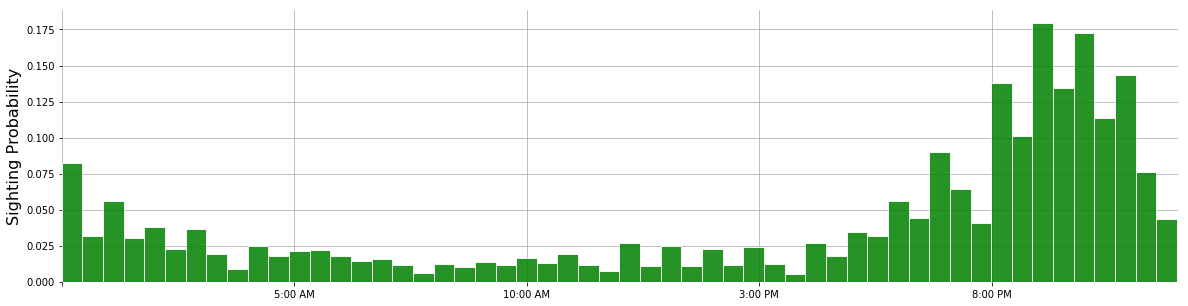

In [12]:
#PLOT HISTOGRAM OF SIGHTINGS BY TIME OF DAY
fig, ax = plt.subplots(figsize=(20,5))
for s in ax.spines: ax.spines[s].set_visible(False)
sighting_times.hist(bins='auto', color='green', edgecolor='white', alpha=0.85, normed=True, zorder=2)
ax.set_ylabel('Sighting Probability',fontsize=16)
ax.set_xlim([0,24])
ax.set_xticklabels(['','5:00 AM','10:00 AM','3:00 PM','8:00 PM'])
plt.show()

Significant portion of UFO's are seen after 8:00 PM local time.

In [13]:
ufo['Date'] = ufo['Occurred'].dt.strftime('%Y-%m-%d') #GET DATE OF SIGHTING

In [14]:
#FORM DATETIME DATAFRAME
datetime_df = pd.concat([ufo.Date, sighting_times],axis=1).dropna()

### Annual dependence?

In [15]:
#YEAR COLUMN
datetime_df['Year'] = datetime_df['Date'].apply(lambda x: x[0:4])
datetime_df = datetime_df[~(datetime_df['Year']=='NaT')].copy()

In [16]:
#LABEL DECADES
decades = ['1940s','1950s','1960s','1970s','1980s','1990s','2000s','2010s']
datetime_df['Decade'] = pd.cut(x=datetime_df['Year'].astype(int),
       bins=[1940,1950,1960,1970,1980,1990,2000,2010,2020],
       labels=decades)

datetime_df = datetime_df.dropna()

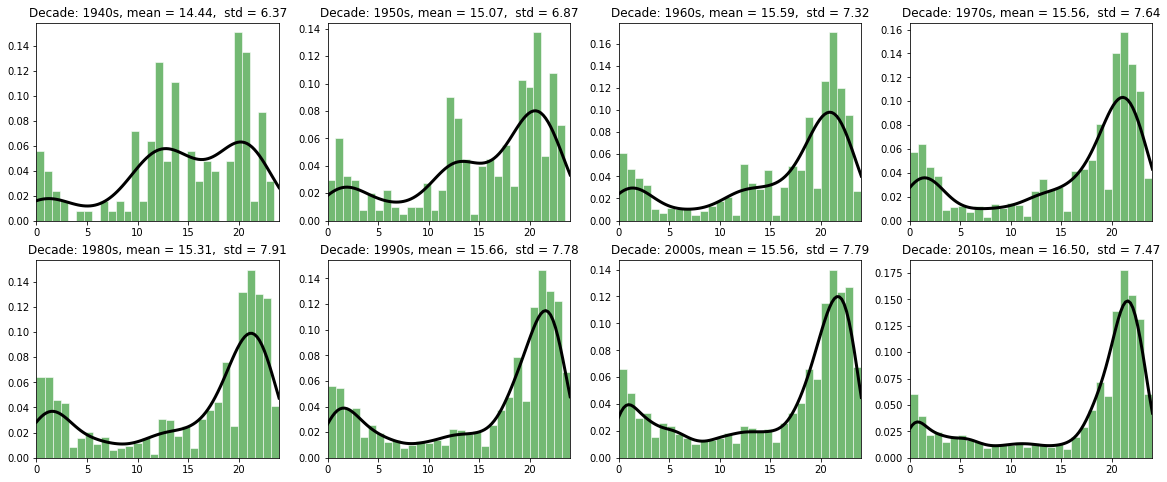

In [17]:
#PLOT DISTRIBUTIONS BY DECADE
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,8))
for i, ax in enumerate(axes.flatten()):
    
    #series
    t = datetime_df[datetime_df['Decade']==decades[i]]['Sighting Time']
    
    #mean and std
    mean = np.mean(t)
    std = np.std(t)

    #histogram
    ax.hist(t, bins=30, density=True, edgecolor='white', alpha=0.55, color='green')

    #probability distribution curve
    xmin = 0
    xmax = 24
    ax.set_xlim([xmin,xmax])
    x = np.linspace(xmin, xmax, 100)
    prob_dist = stats.kde.gaussian_kde(t)(x)
    ax.plot(x, prob_dist, color='black', lw=3.0)
    
    ax.set_title("Decade: {}, mean = {:,.2f},  std = {:,.2f}".format(decades[i], mean, std))

plt.show()

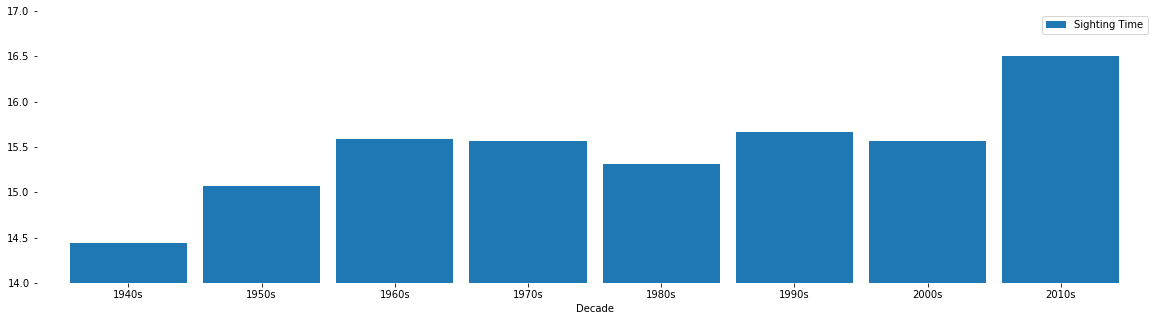

In [18]:
#AVERAGE SIGHTING TIME CHANGES OVER RECENT DECADES
fig, ax = plt.subplots(figsize=(20,5))
for s in ax.spines: ax.spines[s].set_visible(False)
datetime_df[['Decade','Sighting Time']].groupby('Decade').mean().plot(kind='bar', width=0.88, rot=0, ax=ax)
ax.set_ylim([14,17])
plt.show()

### Seasonal dependence?

In [19]:
datetime_df['Season'] = datetime_df['Date'].apply(lambda t: (int(t[5:7])%12 + 3)//3)
season_dict = {1:'Winter',2:'Spring',3:'Summer',4:'Autumn'}
datetime_df['Season'] = datetime_df['Season'].map(season_dict)

In [20]:
datetime_df['Season'].value_counts(normalize=True)

Summer    0.327548
Autumn    0.276639
Spring    0.199386
Winter    0.196427
Name: Season, dtype: float64

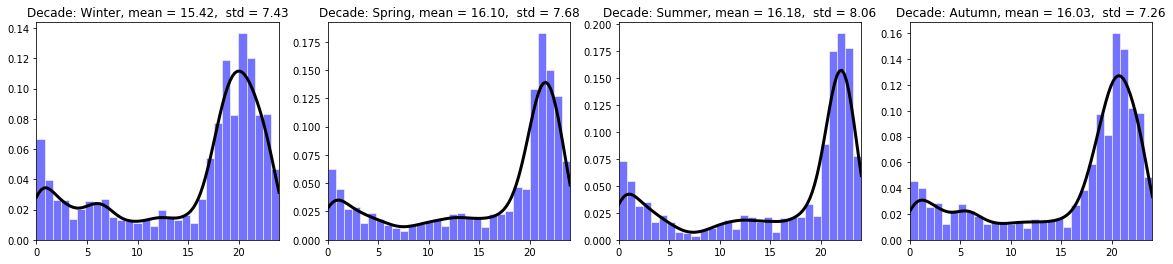

In [21]:
#PLOT DISTRIBUTIONS BY SEASON
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
seasons = list(season_dict.values())
for i, ax in enumerate(axes.flatten()):
    
    #series
    t = datetime_df[datetime_df['Season']==seasons[i]]['Sighting Time']
    
    #mean and std
    mean = np.mean(t)
    std = np.std(t)

    #histogram
    ax.hist(t, bins=30, density=True, edgecolor='white', alpha=0.55, color='blue')

    #probability distribution curve
    xmin = 0
    xmax = 24
    ax.set_xlim([xmin,xmax])
    x = np.linspace(xmin, xmax, 100)
    prob_dist = stats.kde.gaussian_kde(t)(x)
    ax.plot(x, prob_dist, color='black', lw=3.0)
    
    ax.set_title("Decade: {}, mean = {:,.2f},  std = {:,.2f}".format(seasons[i], mean, std))
    
plt.show()

### Date and Time Correlations

In [22]:
def datetime_to_yearday(series):
    #CONVERT DATETIME TO DAY OF THE YEAR
    doys = {x:pd.to_datetime(x).timetuple().tm_yday for x in series.unique()}
    return series.map(doys)

In [23]:
datetime_df['Doy'] = datetime_to_yearday(datetime_df['Date'])
datetime_df['Month'] = datetime_df['Date'].apply(lambda t: int(t[5:7]))
months = {'Jan':1,'Feb':2,'Mar':3,
          'Apr':4,'May':5,'Jun':6,
          'Jul':7,'Aug':8,'Sep':9,
          'Oct':10,'Nov':11,'Dec':12}
inv_months = {v:k for k,v in months.items()}
datetime_df['Month'] = datetime_df['Month'].replace(inv_months)

In [24]:
datetime_df.head()

,Date,Sighting Time,Year,Decade,Season,Doy,Month
0,1996-06-24,0.50,1996,1990s,Summer,176,Jun
2,2018-10-21,0.75,2018,2010s,Autumn,294,Oct
3,2018-10-21,1.00,2018,2010s,Autumn,294,Oct
4,2018-10-21,1.00,2018,2010s,Autumn,294,Oct
5,2018-10-21,1.00,2018,2010s,Autumn,294,Oct


In [25]:
months = pd.get_dummies(datetime_df['Month'])
doys = pd.get_dummies(datetime_df['Doy'])
corr_df = pd.concat([months, doys], axis=1)

In [26]:
def get_redundant_pairs(x):
    """Get diagonal and lower triangular pairs of the correlation matrix."""
    pairs_to_drop = set()
    cols = x.columns
    for i in range(0, x.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(x, n=15):
    au_corr = x.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(x)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [27]:
import warnings
warnings.filterwarnings('ignore')
get_top_abs_correlations(corr_df, n=15)

Jan  1      0.336687
Jul  185    0.326958
Jun  152    0.276065
     166    0.274618
Aug  227    0.248948
Jun  181    0.244198
May  135    0.243187
Jul  196    0.241425
Dec  365    0.240882
Feb  46     0.235238
Mar  74     0.229609
Oct  288    0.228998
Nov  311    0.228716
Jul  186    0.227085
Nov  320    0.224735
dtype: float64

Able to pinpoint many of these top correlations to US holidays!

<ul>
<li>Jan 1.0 - New Year's Day</li>
<li>Jul 185.0 and 186.0 - Independence Day (US)</li>
<li>Jun 166.0 - Flag Day (US)</li>
<li>Dec 365.0 - New Year's Eve</li>
<li>Aug 227.0 - National Airborne Day (US)</li>
<li>May 135.0 - Peace Officers Memorial Day (US) and  Armed Forces Day (US)</li>
<li>Feb 46.0 - Valentine's Day</li>
</ul>

Typical celebrations for these dates are fireworks and air shows, two activities which could understandably be mistaken for UFOs. However, there are a few highly correlated days of the year which aren't accounted for.